# Introduction

Basically we are trying to find the best algorithm to classify the inhibitor types in our binary dataset from KinCoRe that we preprocessed. Here, we are trying out using Logistic Regression, Support Vector Machine, and Random Forest.

The workflow is as follows:
1. load packages, directory, and dataset
2. find the best combination of sampling and standardization/normalization methods that yields the best baseline model
3. run hyperparameter tuning for our model to get the highest metrics score
4. repeat with different algorithms

# Load dataset and directories

In [1]:
# general data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management packages
import csv, sys
import os
import copy
import pickle

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# modeling
from sklearn import preprocessing, model_selection, feature_selection, metrics
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# misc
from textwrap import wrap
import time


In [2]:
os.chdir('../data')

In [3]:
data_db = pd.read_csv('data_binding_desc-03.csv').drop(columns=['Unnamed: 0'])
data_db

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data_db = data_db.replace({'Type1.5_Back':'Type1.5', 'Type1.5_Front':'Type1.5'})
data_db

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5,2169,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='LigandType', ylabel='count'>

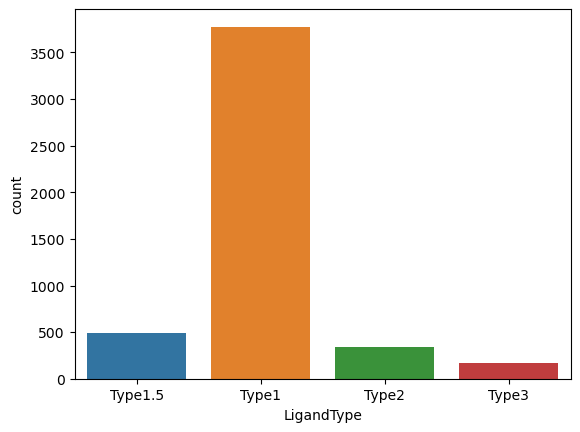

In [5]:
sns.countplot(data_db, x='LigandType')

from here we can see that there are several columns that need to be dropped for the next step, such as `Unnamed: 0` and `lig_smiles`. The column `LigandType` needs to be separated as a target. The rest (209 columns) are features we'll use in the model.

# 0. preprocess data

workflow in this step is the following:
1. drop duplicate and null rows
2. drop feature that begins with `Unnamed` (since it was generated automatically when we did not reset the index in the last step before saving the data from the previous step into csv)
3. encode target using integer (0,1)
4. separate features and target
5. remove features which values don't have variation
6. remove feature that has low correlation with other features
7. split data into train-validation and test set
8. split data into train and validation set

In [4]:
def data_preprocessing(data,
                       target='LigandType', 
                       col_to_drop=['lig_smiles'],
                       test_size=0.2, 
                       val_size=0.2, 
                       random_state=0,
                       anova=True,
                       ):
    '''
    preprocess data from the previous workflow

    Args:
    ----------
      data: pd.DataFrame
        the input data to be preprocesed
      target: str
        target column for the model
      col_to_drop: list
        list of columns to drop
      test_size: float
        test size from the whole input data
      val_size: float
        validation set size from the whole input data
      anova: bool
        initial feature selection option using ANOVA

    Returns:
    ----------
      X_train, X_val, X_test, y_train, y_val, y_test: np.array
        the respective train, validation and test sets
      descnm: np.array
        feature names
    '''

    # drop duplicate rows
    data_ = data.drop_duplicates().dropna()

    # drop cols with 'unnamed'
    colidx_to_drop = [i for i in data.columns if 'Unnamed' in i]

    #encode target
    to_mask = {}

    for i,j in enumerate(data_[target].unique()):
        to_mask.update({j:i})

    data_ = data_.replace(to_mask)

    # separate x and y
    X = data_.loc[:, data_.columns.difference(col_to_drop+[target]+colidx_to_drop)]
    y = data_[target]

    # remove features that don't have variation
    X_out = X.loc[:,X.apply(pd.Series.nunique) != 1]
    mask = X_out.applymap(lambda x: isinstance(x, (int, float)))
    X_out2 = X_out.where(mask)
    X = X_out2.dropna(axis=1)

    if anova == True:
      # anova feature selection
      f_stat, p_val, = f_classif(X, y)

      # get index which probability is lower than p = 0.05
      idx = [i for i,j in enumerate(p_val) if j < 0.05]
      # select column with respective index
      X = X.iloc[:,idx]
    else:
      pass

    # split train-validation and test
    X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    # split train and validation
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainval, y_trainval, test_size = val_size/(1-val_size), random_state=random_state, stratify=y_trainval)

    descnm = np.array(X_train.columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    #return X_trainval, X_test, y_trainval, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test, descnm

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

In [8]:
print(len(y_train))
print(len(y_val))
print(len(y_test))
print(len(y_train)+len(y_val)+len(y_test))

2859
953
953
4765


In [46]:
len(data_db[data_db['LigandType']=='Type3'])

164

In [38]:
print(f'0 = {len([i for i in y_train if i == 0])}')
print(f'1 = {len([i for i in y_train if i == 1])}')
print(f'2 = {len([i for i in y_train if i == 2])}')
print(f'3 = {len([i for i in y_train if i == 3])}')
print('')

print(f'0 = {len([i for i in y_val if i == 0])}')
print(f'1 = {len([i for i in y_val if i == 1])}')
print(f'2 = {len([i for i in y_val if i == 2])}')
print(f'3 = {len([i for i in y_val if i == 3])}')
print('')

print(f'0 = {len([i for i in y_test if i == 0])}')
print(f'1 = {len([i for i in y_test if i == 1])}')
print(f'2 = {len([i for i in y_test if i == 2])}')
print(f'3 = {len([i for i in y_test if i == 3])}')

0 = 292
1 = 2266
2 = 203
3 = 98

0 = 97
1 = 755
2 = 68
3 = 33

0 = 97
1 = 755
2 = 68
3 = 33


In [6]:
data_da_desc = data_db.drop(columns=['Unnamed: 0', 'lig_smiles', 'LigandType', 'lig_at'])#.describe().T
data_da_desc

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.178672,-0.173135,12.178672,0.173135,0.442423,461.518,434.302,461.195071,176,0,...,0,0,0,0,0,0,0,0,0,0
1,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,288.170,296.032088,108,0,...,0,0,0,0,0,0,0,0,0,0
2,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,288.170,296.032088,108,0,...,0,0,0,0,0,0,0,0,0,0
3,5.632207,0.490670,5.632207,0.490670,0.468745,428.496,404.304,428.196074,162,0,...,0,0,0,0,0,0,0,0,0,0
4,13.089887,-0.065059,13.089887,0.036424,0.722645,381.484,354.268,381.227708,148,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4214,6.252538,0.518412,6.252538,0.518412,0.358838,458.518,432.310,458.195405,174,0,...,0,0,0,0,0,0,0,0,0,0
4215,11.222610,-0.469079,11.222610,0.204548,0.767397,333.347,318.227,333.111341,124,0,...,0,0,0,0,0,0,0,0,0,0
4216,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,461.750,476.085160,168,0,...,0,0,0,0,0,0,0,0,0,0
4217,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,461.750,476.085160,168,0,...,0,0,0,0,0,0,0,0,0,0


# 1. find combination of sampling and standardization methods for a baseline model

In [6]:
def find_model(X_train, y_train, X_val, y_val,
                algorithm = 'logreg',
                multiclass = False,
                kernel = 'rbf',
                solver='liblinear',
                max_iter=10000,
                scaling = True,
                random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'LogisticRegression'
            - Support vector machine: 'SVC'
            - Random forest: 'RandomForestClassification'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        #sampling: str
        #    sampling method you wish to use. Available are:
        #    - smote
        #    - random_over
        #    - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        df_find_model
            A DataFrame of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    def model_(X_train, y_train, X_val, y_val,
                      algorithm = algorithm,
                      multiclass = multiclass,
                      kernel = kernel,
                      solver = solver,
                      sampling = 'SMOTE',
                      max_iter=max_iter,
                      scaling = scaling,
                      random_state=random_state):
        '''
        Find the best combination of sampling and
        standardization methods as a baseline model.

        Args:
        ----------
            X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
                Training and validation data and its targts
            algorithm: str
                The algorithm to use. Available are:
                - Logistic regression: 'logreg'
                - Support vector machine: 'svm'
                - Random forest: 'rf'
            multiclass: bool
                Determining whether the classification is binary or multiclass.
                if `True` then the average metrics is computed as weighted
                if `False` then the average metrics is computed as binary
            kernel: str
                only applies in support vector machine. 
                The kernel you wish to run.
            solver: str
                only applies in logistic regression. 
                The solver you wish to run. Default is 'liblinear'.
            sampling: str
                sampling method you wish to use. Available are:
                - smote
                - random_over
                - random_under
            scaling: bool
                scaling (standardization/normalization) of the data.

        Returns:
        ----------
            dict
                A dictionary of the scores between different sampling and scaling methods 
                across metrics of the training and validation data
        '''

        if type(sampling) == str:
            sampling = [sampling]

        for i in sampling:
            if i == 'RandomUnderSampler':
                X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'RandomOverSampler':
                X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'SMOTE':
                X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
            else:
                pass
        
        if algorithm == 'LogisticRegression':
            model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
        elif algorithm == 'SVC':
            model = SVC(kernel=kernel, random_state=random_state)
        else:
            model = RandomForestClassifier(random_state=random_state)
            scaling = False

        # scaling
        if scaling == False:
            train_scaled = {'none':X_train}
            val_scaled = {'none':X_val}
        else:
            X_train_MAS = preprocessing.MaxAbsScaler().fit_transform(X_train)
            X_train_MMS = preprocessing.MinMaxScaler().fit_transform(X_train)
            X_train_SS = preprocessing.StandardScaler().fit_transform(X_train)
            X_train_NORM = preprocessing.Normalizer().fit_transform(X_train)
            X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
            X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
            X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
            X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
            X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
            X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)

            train_scaled = {
                'none':X_train,
                'MaxAbsScaler':X_train_MAS,
                'MinMaxScaler':X_train_MMS,
                'StandardScaler':X_train_SS,
                'Normalizer':X_train_NORM,
                'Normalizer + MaxAbsScaler':X_train_NMAS,
                'Normalizer + MinMaxScaler':X_train_NMMS,
                'Normalizer + StandardScaler':X_train_NSS,
                'MaxAbsScaler + Normalizer':X_train_MASNORM,
                'MinMaxScaler + Normalizer':X_train_MMSNORM,
                'StandardScaler + Normalizer':X_train_SSNORM,
                }

        output_dict= {
            'sampling': [],
            'scaling': [],
            'train_accuracy': [],
            'train_f1': [],
            'train_ba':[],
            'train_mcc':[],
            'train_cf': [],
            'val_accuracy':[],
            'val_f1':[],
            'val_ba':[],
            'val_mcc':[],
            'val_cf': [],
        }

        for sampl in sampling:
            for scaler, scaled in train_scaled.items():
                fit = model.fit(scaled, y_train)
                y_pred = fit.predict(scaled)
                y_val_pred = fit.predict(X_val)


                # calculate statistical metrics accuracy for training set
                train_accuracy = metrics.accuracy_score(y_train, y_pred)
                val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

                if multiclass == True:
                    # calculate statistical metrics for training set
                    train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                    train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                    train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                    train_cf = metrics.confusion_matrix(y_train, y_pred)

                    # calculate statistical metrics for val set
                    val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                    val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                    val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                    val_cf = metrics.confusion_matrix(y_val, y_val_pred)
                else:
                    # calculate statistical metrics for training set
                    train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                    train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                    train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                    train_cf = metrics.confusion_matrix(y_train, y_pred)

                    # calculate statistical metrics for val set
                    val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                    val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                    val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                    val_cf = metrics.confusion_matrix(y_val, y_val_pred)


                output_dict['sampling'].append(sampl)
                output_dict['scaling'].append(scaler)
                # train metrics
                output_dict['train_accuracy'].append(train_accuracy)
                output_dict['train_f1'].append(train_f1)
                output_dict['train_ba'].append(train_ba)
                output_dict['train_mcc'].append(train_mcc)
                output_dict['train_cf'].append(train_cf)
                # val metrics
                output_dict['val_accuracy'].append(val_accuracy)
                output_dict['val_f1'].append(val_f1)
                output_dict['val_ba'].append(val_ba)
                output_dict['val_mcc'].append(val_mcc)
                output_dict['val_cf'].append(val_cf)
        return output_dict

    
    model_smote = model_(X_train, y_train, X_val, y_val, sampling = 'SMOTE', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_under = model_(X_train, y_train, X_val, y_val, sampling = 'RandomUnderSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_over = model_(X_train, y_train, X_val, y_val, sampling = 'RandomOverSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_nosampling = model_(X_train, y_train, X_val, y_val, sampling = 'no_sampling', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)

    df_model = []
    for i in [model_smote, model_under, model_over, model_nosampling]:
        df = pd.DataFrame.from_dict(i)
        df_model.append(df)

    df_find_model = pd.concat(df_model, ignore_index=True)
    df_find_model = df_find_model.sort_values(by=['val_ba', 'val_mcc', 'train_ba', 'train_mcc'], ascending=False).round(3)
    #df_find_model.to_csv('linreg_allo_rdkit_model_baseline.csv')

    return df_find_model


get new standardized and sampled data

In [7]:
def sampled_scaled(X_train, y_train, 
            sampling = 'SMOTE',
            scaling = True,
            random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training data and its targets after sampled and scaled
    '''

    if type(sampling) == str:
        sampling = [sampling]
    if type(scaling) == str:
        scaling = [scaling]

    for i in sampling:
        if i == 'random_under':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'random_over':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass

    # scaling
    for j in scaling:
        if j == 'MaxAbsScaler':
            X_train = preprocessing.MaxAbsScaler().fit_transform(X_train)
        elif j == 'MinMaxScaler':
            X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        elif j == 'StandardScaler':
            X_train = preprocessing.StandardScaler().fit_transform(X_train)
        elif j == 'Normalizer':
            X_train = preprocessing.Normalizer().fit_transform(X_train)
        #elif j == 'MaxAbsScalerN':
        #    X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        #elif j == 'MinMaxScalerN':
        #    X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        #elif j == 'StandardScalerN':
        #    X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        #elif j == 'NMaxAbsScaler':
        #    X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        #elif j == 'NMinMaxScaler':
        #    X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        #elif j == 'NStandardScaler':
        #    X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)
        else:
            pass

    return X_train, y_train



# logistic regression

#### lbfgs

In [24]:
start_time = time.time()
model_lbfgs = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                      multiclass=True, 
                                      algorithm='LogisticRegression', 
                                      solver='lbfgs'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_lbfgs = end_time-start_time
print(f"Operation took {duration_lbfgs} seconds.")

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Operation took 84.48786091804504 seconds.


In [38]:
model_lbfgs.to_csv('db_lr_lbfgs.csv')

In [26]:
model_lbfgs

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
40,no_sampling,Normalizer + StandardScaler,0.836,0.767,0.231,0.176,"[[3, 79, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.096,0.096,0.215,0.036,"[[0, 0, 0, 28, 0], [0, 38, 25, 635, 0], [0, 1,..."
39,no_sampling,Normalizer + MinMaxScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.204,0.268,0.215,0.030,"[[0, 1, 0, 27, 0], [0, 136, 0, 562, 0], [0, 13..."
37,no_sampling,Normalizer,0.830,0.753,0.200,0.000,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.082,0.094,0.212,0.029,"[[28, 0, 0, 0, 0], [657, 41, 0, 0, 0], [56, 2,..."
14,RandomUnderSampler,StandardScaler,0.750,0.750,0.750,0.688,"[[42, 2, 5, 2, 1], [3, 38, 3, 3, 5], [0, 4, 40...",0.053,0.011,0.211,0.014,"[[0, 0, 0, 28, 0], [4, 0, 60, 634, 0], [0, 0, ..."
29,RandomOverSampler,Normalizer + StandardScaler,0.351,0.324,0.351,0.240,"[[1898, 0, 96, 26, 76], [1222, 443, 170, 144, ...",0.077,0.063,0.209,0.023,"[[0, 0, 0, 28, 0], [0, 25, 0, 656, 17], [0, 0,..."
38,no_sampling,Normalizer + MaxAbsScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.219,0.290,0.209,0.024,"[[0, 1, 0, 27, 0], [0, 150, 0, 548, 0], [0, 14..."
26,RandomOverSampler,Normalizer,0.204,0.098,0.204,0.010,"[[0, 126, 1970, 0, 0], [132, 221, 1743, 0, 0],...",0.058,0.051,0.206,0.033,"[[28, 0, 0, 0, 0], [677, 21, 0, 0, 0], [58, 0,..."
7,SMOTE,Normalizer + StandardScaler,0.377,0.356,0.377,0.292,"[[1986, 5, 89, 14, 2], [1268, 453, 152, 107, 1...",0.043,0.045,0.205,0.020,"[[0, 0, 0, 0, 28], [0, 19, 0, 0, 679], [0, 0, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.294,0.232,0.294,0.208,"[[2063, 0, 5, 0, 28], [1622, 236, 50, 37, 151]...",0.042,0.042,0.205,0.017,"[[0, 0, 0, 0, 28], [2, 18, 0, 1, 677], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.044,"[[0, 3, 49, 0, 0], [1, 7, 44, 0, 0], [0, 3, 49...",0.103,0.077,0.205,0.024,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."


In [27]:
model_lbfgs_melted = pd.melt(model_lbfgs, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_lbfgs_melted = model_lbfgs_melted.drop(model_lbfgs_melted[model_lbfgs_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_lbfgs_melted['set'] = np.where(model_lbfgs_melted['metrics'].str.startswith('train'), 'train', 'val')
model_lbfgs_melted['met'] = np.where(model_lbfgs_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_lbfgs_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_lbfgs_melted['sampling'] = np.where(model_lbfgs_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_lbfgs_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_lbfgs_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_lbfgs_melted = model_lbfgs_melted.drop(columns=['metrics'])
model_lbfgs_melted


,sampling,scaling,value,set,met
44,No Sampling,Normalizer + StandardScaler,0.767,train,f1
45,No Sampling,Normalizer + MinMaxScaler,0.754,train,f1
46,No Sampling,Normalizer,0.753,train,f1
47,Random Undersampler,StandardScaler,0.750,train,f1
48,Random Oversampler,Normalizer + StandardScaler,0.324,train,f1
...,...,...,...,...,...
347,Random Oversampler,MaxAbsScaler + Normalizer,-0.030,val,mcc
348,No Sampling,MinMaxScaler + Normalizer,-0.030,val,mcc
349,Random Oversampler,MinMaxScaler + Normalizer,-0.032,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.037,val,mcc


In [14]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='train'].value.mean()

/var/folders/zh/6tz72s157dsdk3fzz1x9rvfc0000gn/T/ipykernel_93117/3265252411.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='train'].value.mean()


0.6120681818181818

In [15]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='val'].value.mean()

/var/folders/zh/6tz72s157dsdk3fzz1x9rvfc0000gn/T/ipykernel_93117/787339492.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='val'].value.mean()


0.5360227272727273

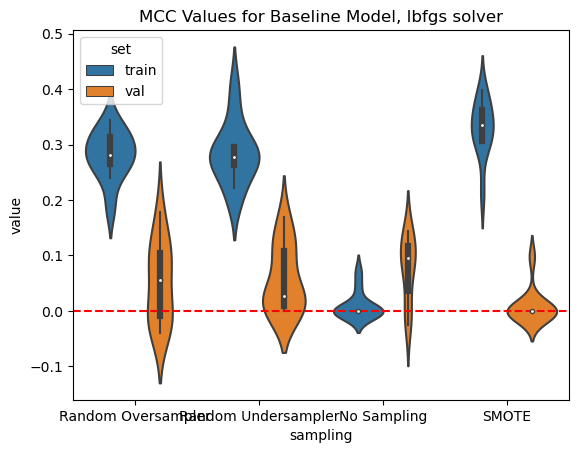

In [16]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, lbfgs solver')
plt.show()


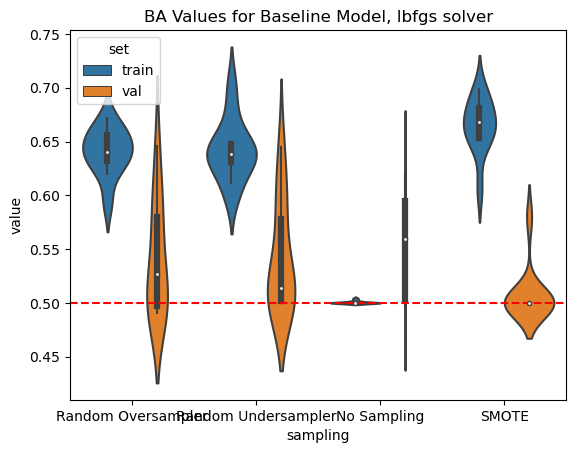

In [17]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, lbfgs solver')
plt.show()


#### liblinear

In [63]:
start_time = time.time()
model_liblinear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                          algorithm='LogisticRegression', solver='liblinear',
                                          multiclass=True))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_liblinear = end_time-start_time
print(f"Operation took {duration_liblinear} seconds.")

Operation took 158.0603621006012 seconds.


In [65]:
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
22,RandomOverSampler,none,0.804,0.801,0.804,0.739,"[[1636, 402, 180, 48], [370, 1539, 137, 220], ...",0.678,0.719,0.706,0.428,"[[60, 22, 15, 0], [142, 506, 39, 68], [7, 1, 5..."
0,SMOTE,none,0.817,0.815,0.817,0.756,"[[1726, 384, 125, 31], [395, 1539, 125, 207], ...",0.657,0.702,0.697,0.412,"[[62, 20, 14, 1], [157, 486, 38, 74], [9, 1, 5..."
11,RandomUnderSampler,none,0.832,0.831,0.832,0.776,"[[76, 15, 5, 2], [10, 75, 2, 11], [4, 2, 88, 4...",0.596,0.649,0.694,0.379,"[[66, 17, 12, 2], [192, 423, 42, 98], [8, 1, 5..."
33,no_sampling,none,0.853,0.828,0.551,0.521,"[[63, 215, 14, 0], [23, 2212, 27, 4], [12, 62,...",0.841,0.820,0.524,0.482,"[[26, 65, 6, 0], [17, 728, 6, 4], [9, 23, 36, ..."
4,SMOTE,Normalizer,0.483,0.471,0.483,0.322,"[[878, 331, 811, 246], [481, 597, 820, 368], [...",0.429,0.503,0.346,0.085,"[[0, 42, 1, 54], [0, 380, 2, 373], [0, 25, 0, ..."
26,RandomOverSampler,Normalizer,0.460,0.451,0.460,0.288,"[[800, 364, 837, 265], [473, 669, 761, 363], [...",0.700,0.663,0.322,0.048,"[[0, 87, 0, 10], [0, 653, 0, 102], [0, 60, 0, ..."
23,RandomOverSampler,MaxAbsScaler,0.812,0.809,0.812,0.749,"[[1669, 327, 192, 78], [377, 1568, 126, 195], ...",0.101,0.031,0.301,0.042,"[[47, 0, 50, 0], [302, 0, 453, 0], [19, 0, 49,..."
24,RandomOverSampler,MinMaxScaler,0.813,0.811,0.813,0.751,"[[1678, 334, 183, 71], [379, 1570, 126, 191], ...",0.097,0.029,0.296,0.037,"[[38, 0, 59, 0], [259, 0, 496, 0], [14, 0, 54,..."
8,SMOTE,MaxAbsScaler + Normalizer,0.799,0.797,0.799,0.733,"[[1722, 307, 182, 55], [404, 1484, 133, 245], ...",0.094,0.030,0.296,0.044,"[[32, 0, 65, 0], [177, 0, 578, 0], [10, 0, 58,..."
1,SMOTE,MaxAbsScaler,0.838,0.835,0.838,0.784,"[[1755, 337, 145, 29], [375, 1602, 119, 170], ...",0.095,0.034,0.293,0.040,"[[32, 0, 65, 0], [190, 2, 563, 0], [11, 0, 57,..."


In [39]:
model_liblinear.to_csv('db_lr_liblinear.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
6,SMOTE,Normalizer + MinMaxScaler,0.290,0.226,0.290,0.200,"[[2060, 0, 6, 0, 30], [1632, 225, 53, 41, 145]...",0.069,0.049,0.216,0.017,"[[0, 0, 0, 27, 1], [1, 19, 0, 564, 114], [0, 0..."
29,RandomOverSampler,Normalizer + StandardScaler,0.350,0.321,0.350,0.245,"[[1949, 0, 96, 26, 25], [1258, 448, 170, 108, ...",0.075,0.058,0.209,0.021,"[[0, 0, 0, 28, 0], [0, 23, 0, 660, 15], [0, 0,..."
26,RandomOverSampler,Normalizer,0.203,0.099,0.203,0.008,"[[0, 126, 1970, 0, 0], [119, 233, 1743, 1, 0],...",0.062,0.057,0.207,0.022,"[[28, 0, 0, 0, 0], [674, 24, 0, 0, 0], [57, 1,..."
4,SMOTE,Normalizer,0.236,0.141,0.236,0.084,"[[2001, 56, 5, 2, 32], [1664, 211, 17, 3, 201]...",0.042,0.042,0.205,0.022,"[[0, 0, 0, 0, 28], [0, 18, 4, 0, 676], [0, 0, ..."
16,RandomUnderSampler,Normalizer + MaxAbsScaler,0.292,0.247,0.292,0.201,"[[3, 0, 49, 0, 0], [0, 12, 40, 0, 0], [0, 3, 4...",0.103,0.077,0.205,0.030,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.372,0.346,0.372,0.288,"[[2005, 1, 82, 0, 8], [1309, 452, 125, 73, 137...",0.040,0.040,0.205,0.017,"[[0, 0, 0, 0, 28], [0, 17, 0, 0, 681], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.046,"[[0, 3, 49, 0, 0], [0, 7, 45, 0, 0], [0, 3, 49...",0.112,0.094,0.204,0.028,"[[0, 0, 28, 0, 0], [1, 38, 659, 0, 0], [1, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.290,0.226,0.290,0.201,"[[2062, 0, 6, 0, 28], [1630, 235, 53, 37, 141]...",0.070,0.051,0.203,0.013,"[[0, 0, 0, 28, 0], [1, 20, 0, 621, 56], [0, 0,..."
18,RandomUnderSampler,Normalizer + StandardScaler,0.404,0.395,0.404,0.305,"[[46, 0, 2, 3, 1], [30, 14, 2, 3, 3], [27, 3, ...",0.024,0.005,0.202,-0.000,"[[0, 0, 0, 0, 28], [0, 0, 55, 0, 643], [0, 0, ..."
40,no_sampling,Normalizer + StandardScaler,0.835,0.764,0.226,0.157,"[[2, 80, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.090,0.088,0.201,0.021,"[[0, 0, 0, 28, 0], [0, 37, 0, 661, 0], [0, 1, ..."


In [23]:
model_liblinear.to_csv('da_lr_liblinear.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
22,RandomOverSampler,none,0.672,0.676,0.672,0.344,"[[1381, 714], [660, 1435]]",0.672,0.789,0.645,0.177,"[[44, 28], [225, 474]]"
20,RandomUnderSampler,MinMaxScaler + Normalizer,0.631,0.628,0.631,0.263,"[[139, 78], [82, 135]]",0.564,0.696,0.629,0.150,"[[51, 21], [315, 384]]"
19,RandomUnderSampler,MaxAbsScaler + Normalizer,0.611,0.610,0.611,0.221,"[[133, 84], [85, 132]]",0.560,0.693,0.620,0.140,"[[50, 22], [317, 382]]"
43,no_sampling,StandardScaler + Normalizer,0.906,0.951,0.500,0.000,"[[0, 217], [0, 2095]]",0.555,0.690,0.599,0.115,"[[47, 25], [318, 381]]"
11,RandomUnderSampler,none,0.700,0.703,0.700,0.401,"[[150, 67], [63, 154]]",0.604,0.735,0.595,0.112,"[[42, 30], [275, 424]]"
30,RandomOverSampler,MaxAbsScaler + Normalizer,0.620,0.627,0.620,0.240,"[[1261, 834], [758, 1337]]",0.516,0.652,0.590,0.105,"[[49, 23], [350, 349]]"
31,RandomOverSampler,MinMaxScaler + Normalizer,0.628,0.634,0.628,0.256,"[[1276, 819], [741, 1354]]",0.525,0.662,0.582,0.096,"[[47, 25], [341, 358]]"
0,SMOTE,none,0.688,0.686,0.688,0.375,"[[1449, 646], [663, 1432]]",0.647,0.773,0.581,0.099,"[[36, 36], [236, 463]]"
15,RandomUnderSampler,Normalizer,0.599,0.601,0.599,0.198,"[[129, 88], [86, 131]]",0.722,0.831,0.579,0.105,"[[29, 43], [171, 528]]"
26,RandomOverSampler,Normalizer,0.593,0.599,0.593,0.185,"[[1210, 885], [822, 1273]]",0.309,0.395,0.569,0.094,"[[64, 8], [525, 174]]"


In [43]:
model_liblinear_melted = pd.melt(model_liblinear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_liblinear_melted = model_liblinear_melted.drop(model_liblinear_melted[model_liblinear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_liblinear_melted['set'] = np.where(model_liblinear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_liblinear_melted['met'] = np.where(model_liblinear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_liblinear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_liblinear_melted['sampling'] = np.where(model_liblinear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_liblinear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_liblinear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_liblinear_melted = model_liblinear_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_liblinear_melted


,sampling,scaling,value,set,met
53,No Sampling,Normalizer + StandardScaler,0.764,train,f1
61,No Sampling,StandardScaler,0.754,train,f1
62,No Sampling,Normalizer + MaxAbsScaler,0.754,train,f1
66,No Sampling,none,0.753,train,f1
67,No Sampling,MaxAbsScaler,0.753,train,f1
...,...,...,...,...,...
322,SMOTE,MaxAbsScaler,0.000,val,mcc
327,SMOTE,none,0.000,val,mcc
336,SMOTE,StandardScaler + Normalizer,-0.009,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.033,val,mcc


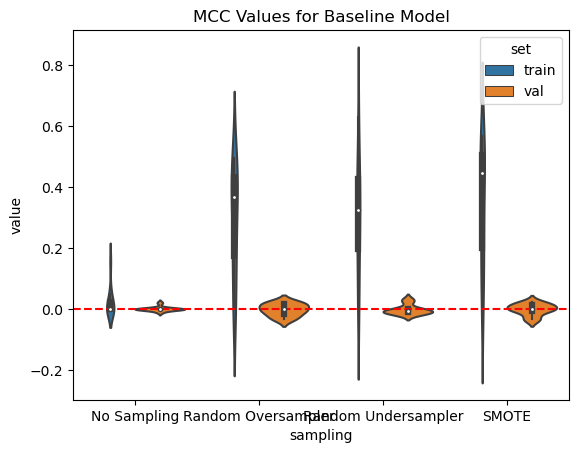

In [44]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model')
plt.show()


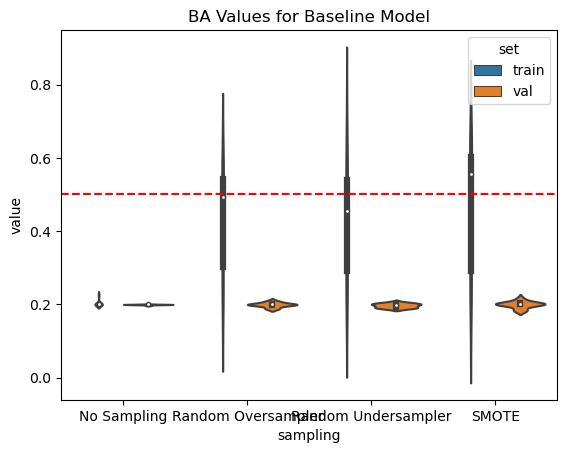

In [45]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model')
plt.show()


#### saga

In [31]:
start_time = time.time()
model_saga = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                     multiclass=True,
                                     algorithm='LogisticRegression', solver='saga'))#.to_csv('da_lr_saga.csv')
end_time = time.time()
duration_saga = end_time-start_time
print(f"Operation took {duration_saga} seconds.")
model_saga

Operation took 1638.3135950565338 seconds.


,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
38,no_sampling,Normalizer + MaxAbsScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.476,0.556,0.239,0.077,"[[0, 7, 0, 21, 0], [0, 374, 0, 324, 0], [0, 28..."
40,no_sampling,Normalizer + StandardScaler,0.836,0.767,0.231,0.176,"[[3, 79, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.096,0.097,0.215,0.043,"[[0, 0, 0, 28, 0], [0, 38, 9, 651, 0], [0, 1, ..."
37,no_sampling,Normalizer,0.830,0.753,0.200,0.000,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.083,0.096,0.212,0.031,"[[28, 0, 0, 0, 0], [656, 42, 0, 0, 0], [56, 2,..."
14,RandomUnderSampler,StandardScaler,0.746,0.746,0.746,0.683,"[[42, 2, 5, 2, 1], [3, 38, 3, 3, 5], [0, 4, 39...",0.053,0.011,0.211,0.015,"[[0, 0, 0, 28, 0], [4, 0, 58, 636, 0], [0, 0, ..."
29,RandomOverSampler,Normalizer + StandardScaler,0.348,0.319,0.348,0.239,"[[1949, 0, 72, 75, 0], [1244, 436, 179, 133, 1...",0.082,0.071,0.210,0.022,"[[0, 0, 0, 28, 0], [0, 29, 0, 645, 24], [0, 1,..."
26,RandomOverSampler,Normalizer,0.204,0.098,0.204,0.010,"[[0, 126, 1970, 0, 0], [135, 221, 1740, 0, 0],...",0.058,0.051,0.206,0.033,"[[28, 0, 0, 0, 0], [677, 21, 0, 0, 0], [58, 0,..."
17,RandomUnderSampler,Normalizer + MinMaxScaler,0.338,0.301,0.338,0.203,"[[42, 0, 9, 0, 1], [24, 12, 16, 0, 0], [26, 2,...",0.106,0.081,0.206,0.027,"[[0, 0, 28, 0, 0], [4, 32, 662, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.368,0.346,0.368,0.280,"[[1969, 6, 89, 32, 0], [1302, 440, 147, 87, 12...",0.043,0.045,0.205,0.020,"[[0, 0, 0, 0, 28], [0, 19, 0, 0, 679], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.044,"[[0, 3, 49, 0, 0], [1, 7, 44, 0, 0], [0, 3, 49...",0.103,0.077,0.205,0.024,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.294,0.232,0.294,0.208,"[[2063, 0, 5, 0, 28], [1623, 236, 50, 37, 150]...",0.040,0.040,0.205,0.015,"[[0, 0, 0, 0, 28], [2, 17, 0, 1, 678], [0, 0, ..."


In [40]:
model_saga.to_csv('db_lr_saga.csv')

In [46]:
model_saga_melted = pd.melt(model_saga, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_saga_melted = model_saga_melted.drop(model_saga_melted[model_saga_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_saga_melted['set'] = np.where(model_saga_melted['metrics'].str.startswith('train'), 'train', 'val')
model_saga_melted['met'] = np.where(model_saga_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_saga_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_saga_melted['sampling'] = np.where(model_saga_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_saga_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_saga_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_saga_melted = model_saga_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_saga_melted


,sampling,scaling,value,set,met
44,No Sampling,Normalizer + MaxAbsScaler,0.754,train,f1
45,No Sampling,Normalizer + StandardScaler,0.767,train,f1
46,No Sampling,Normalizer,0.753,train,f1
64,No Sampling,StandardScaler,0.761,train,f1
65,No Sampling,Normalizer + MinMaxScaler,0.754,train,f1
...,...,...,...,...,...
323,SMOTE,MinMaxScaler,0.000,val,mcc
324,SMOTE,MaxAbsScaler,0.000,val,mcc
330,SMOTE,none,0.000,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.038,val,mcc


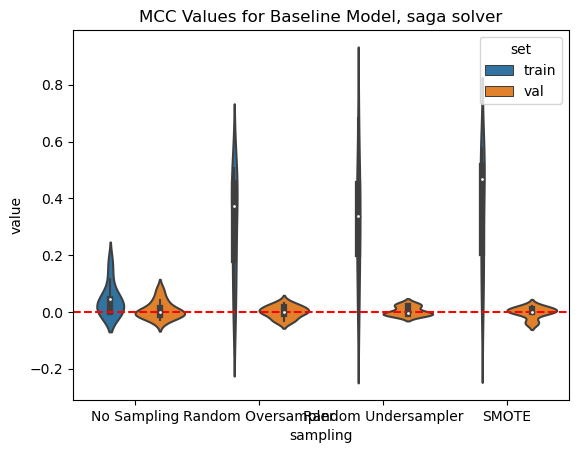

In [47]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.title('MCC Values for Baseline Model, saga solver')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


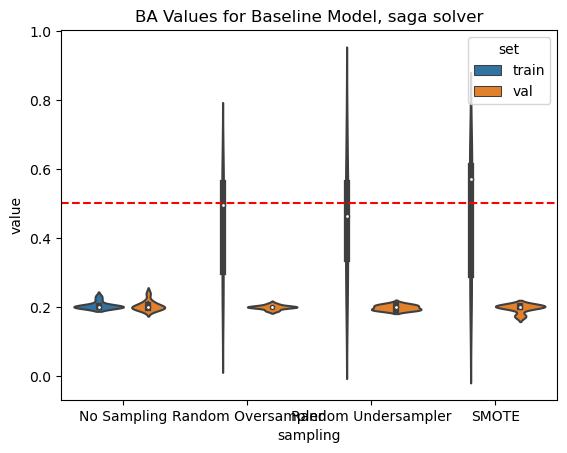

In [48]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, saga solver')
plt.show()


#### plot for all solvers

In [55]:
model_liblinear_melted[model_liblinear_melted['met']=='ba'].sort_values(['value'])

,sampling,scaling,value,set,met
307,SMOTE,MinMaxScaler + Normalizer,0.184,val,ba
306,SMOTE,MaxAbsScaler + Normalizer,0.184,val,ba
304,Random Oversampler,MaxAbsScaler + Normalizer,0.189,val,ba
305,Random Oversampler,MinMaxScaler + Normalizer,0.189,val,ba
301,Random Undersampler,MaxAbsScaler + Normalizer,0.190,val,ba
...,...,...,...,...,...
102,SMOTE,MaxAbsScaler,0.600,train,ba
101,SMOTE,MinMaxScaler,0.602,train,ba
116,SMOTE,StandardScaler + Normalizer,0.604,train,ba
100,SMOTE,StandardScaler,0.652,train,ba


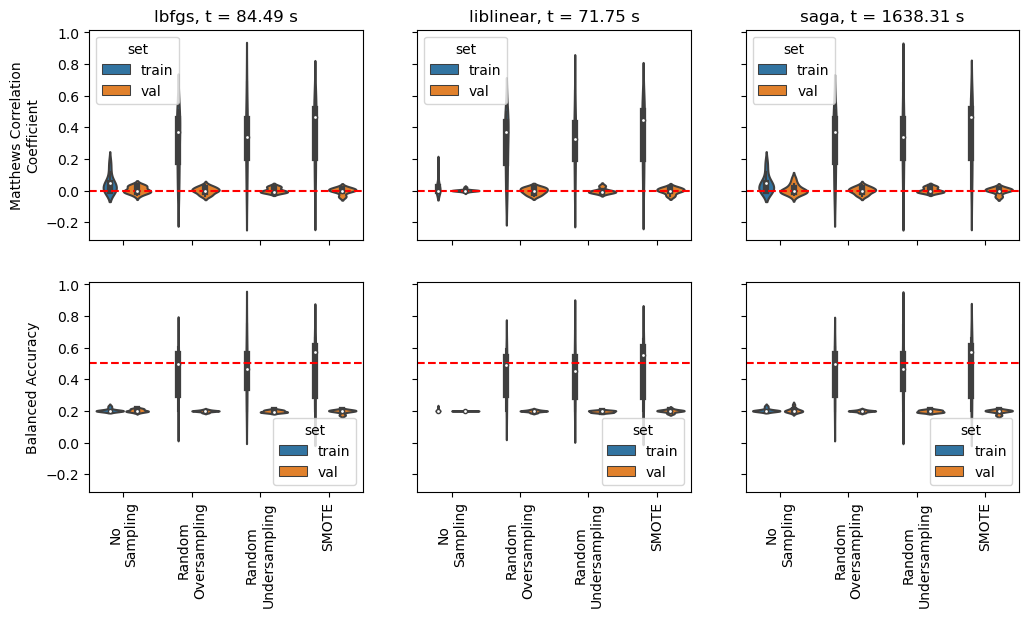

In [41]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'lbfgs, t = {round(duration_lbfgs, 2)} s')
ax[0, 1].set_title(f'liblinear, t = {round(duration_liblinear, 2)} s')
ax[0, 2].set_title(f'saga, t = {round(duration_saga, 2)} s')

for i, j in enumerate([model_lbfgs_melted, model_liblinear_melted, model_saga_melted]):
    sns.violinplot(data=j[j['met']=='mcc'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

In [56]:
model_liblinear#_melted

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
6,SMOTE,Normalizer + MinMaxScaler,0.290,0.226,0.290,0.200,"[[2060, 0, 6, 0, 30], [1632, 225, 53, 41, 145]...",0.069,0.049,0.216,0.017,"[[0, 0, 0, 27, 1], [1, 19, 0, 564, 114], [0, 0..."
29,RandomOverSampler,Normalizer + StandardScaler,0.350,0.321,0.350,0.245,"[[1949, 0, 96, 26, 25], [1258, 448, 170, 108, ...",0.075,0.058,0.209,0.021,"[[0, 0, 0, 28, 0], [0, 23, 0, 660, 15], [0, 0,..."
26,RandomOverSampler,Normalizer,0.203,0.099,0.203,0.008,"[[0, 126, 1970, 0, 0], [119, 233, 1743, 1, 0],...",0.062,0.057,0.207,0.022,"[[28, 0, 0, 0, 0], [674, 24, 0, 0, 0], [57, 1,..."
4,SMOTE,Normalizer,0.236,0.141,0.236,0.084,"[[2001, 56, 5, 2, 32], [1664, 211, 17, 3, 201]...",0.042,0.042,0.205,0.022,"[[0, 0, 0, 0, 28], [0, 18, 4, 0, 676], [0, 0, ..."
16,RandomUnderSampler,Normalizer + MaxAbsScaler,0.292,0.247,0.292,0.201,"[[3, 0, 49, 0, 0], [0, 12, 40, 0, 0], [0, 3, 4...",0.103,0.077,0.205,0.030,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.372,0.346,0.372,0.288,"[[2005, 1, 82, 0, 8], [1309, 452, 125, 73, 137...",0.040,0.040,0.205,0.017,"[[0, 0, 0, 0, 28], [0, 17, 0, 0, 681], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.046,"[[0, 3, 49, 0, 0], [0, 7, 45, 0, 0], [0, 3, 49...",0.112,0.094,0.204,0.028,"[[0, 0, 28, 0, 0], [1, 38, 659, 0, 0], [1, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.290,0.226,0.290,0.201,"[[2062, 0, 6, 0, 28], [1630, 235, 53, 37, 141]...",0.070,0.051,0.203,0.013,"[[0, 0, 0, 28, 0], [1, 20, 0, 621, 56], [0, 0,..."
18,RandomUnderSampler,Normalizer + StandardScaler,0.404,0.395,0.404,0.305,"[[46, 0, 2, 3, 1], [30, 14, 2, 3, 3], [27, 3, ...",0.024,0.005,0.202,-0.000,"[[0, 0, 0, 0, 28], [0, 0, 55, 0, 643], [0, 0, ..."
40,no_sampling,Normalizer + StandardScaler,0.835,0.764,0.226,0.157,"[[2, 80, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.090,0.088,0.201,0.021,"[[0, 0, 0, 28, 0], [0, 37, 0, 661, 0], [0, 1, ..."


## feature importance

In [68]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.628
balanced accuracy: 0.631
matthews corrcoeff: 0.263
cf:
[[139  78]
 [ 82 135]]

val scores 

f1: 0.696
balanced accuracy: 0.629
matthews corrcoeff: 0.150
cf:
[[ 51  21]
 [315 384]]


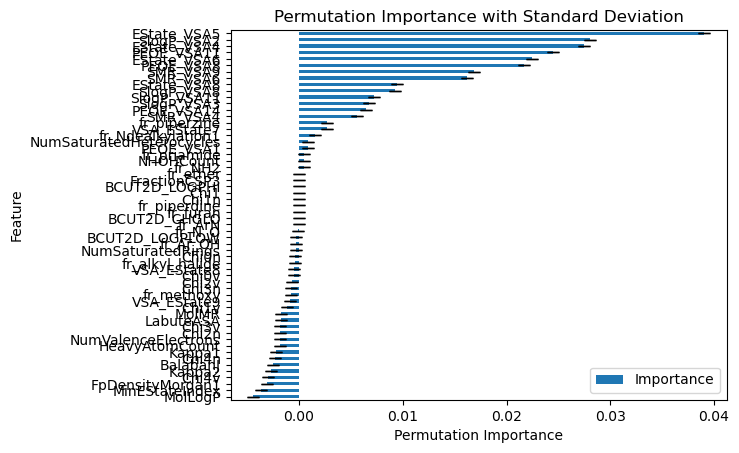

In [41]:
result = permutation_importance(fit, X_val, y_val, n_repeats=10, random_state=random_state)

feature_importance = pd.DataFrame({'Feature': descnm,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                             
                            yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')
plt.tight_layout
plt.show()

In [45]:
feature_importance[feature_importance['Importance'] > 0].Feature.to_list()

['fr_NH2',
 'NHOHCount',
 'fr_priamide',
 'PEOE_VSA1',
 'NumSaturatedHeterocycles',
 'fr_Ndealkylation1',
 'VSA_EState7',
 'fr_piperzine',
 'SMR_VSA4',
 'PEOE_VSA14',
 'SlogP_VSA3',
 'SlogP_VSA11',
 'SlogP_VSA8',
 'EState_VSA8',
 'SMR_VSA6',
 'SMR_VSA9',
 'PEOE_VSA8',
 'EState_VSA6',
 'PEOE_VSA11',
 'EState_VSA4',
 'SlogP_VSA2',
 'EState_VSA5']

### retrain

In [62]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da[features_])

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.593
balanced accuracy: 0.604
matthews corrcoeff: 0.209
cf:
[[127  74]
 [ 85 116]]

val scores 

f1: 0.159
balanced accuracy: 0.521
matthews corrcoeff: 0.047
cf:
[[ 64   3]
 [505  48]]


## hyperparameter tuning using gridsearch

In [8]:
def grid_search(X_train, y_train,
                param_grid,
                algorithm = 'LogisticRegression',
                fold = 3,
                scoring='balanced_accuracy',
                random_state=0,
                ):
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(random_state=random_state)
    elif algorithm == 'SVC':
        model = SVC(random_state=random_state)
    elif algorithm == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=random_state)
    else:
        pass

    cv_ = model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=fold,
        verbose=3,
        scoring=scoring,
        )
    cv_.fit(X_train, y_train)

    return cv_.cv_results_, cv_.best_params_


In [13]:
param_grid = {
    'solver': ['liblinear', 'lbfgs', 'saga',],# 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'class_weight':[None, 'balanced'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'max_iter': [10000],
    'random_state':[0]
}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='LogisticRegression',)

cv_params

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=N

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time= 4.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time= 3.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time= 3.1min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  58.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time= 1.5min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time= 4.9min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time= 4.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time= 5.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time= 2.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time= 2.1min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time= 4.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time= 2.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time= 2.3min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  37.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  41.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time= 1.2min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_cla

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time= 2.0min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time= 4.9min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time= 3.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time= 2.0min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  53.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  51.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  56.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  56.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time= 1.6min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, rando

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  42.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  45.8s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  20.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  28.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time= 1.1min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time=  57.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time=  56.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time= 1.7min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.2s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multino

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time= 2.2min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  36.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  26.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  36.8s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  42.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time= 1.9min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time= 1.4min
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.250 total time=  22.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.283 total time=  18.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.271 total time=  22.5s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  59.1s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_ite

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  20.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  20.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  17.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  45.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  41.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  41.5s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  20.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  24.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  22.5s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  24.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  35.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  32.2s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time=  51.7s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, p

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time= 3.6min
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  52.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  59.3s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penal

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.250 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.283 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.232 total time= 1.6min
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.308 total time=   0.2s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.312 total time=   0.1s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.303 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.251 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.277 total time= 1.1min
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=1

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  18.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  17.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  18.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  48.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  40.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  40.3s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, ra

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  43.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  52.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  45.2s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.296 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.310 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, r

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.269 total time=  34.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.228 total time=  33.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-pack

[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.279 total time=  33.5s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time=  30.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time=  29.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time=  33.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time=  58.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  57.9s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  53.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.283 total time=  52.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.232 total time=  53.2s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.308 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.312 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.303 total time=  40.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.251 total time=  40.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.277 total time=  41.6s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] EN

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  13.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  14.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  14.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  41.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  40.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  41.1s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lb

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  14.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  13.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  15.1s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  18.6s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  20.3s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  26.1s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, sc

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time=  29.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time=  25.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time=  31.4s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time=  37.5s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time=  33.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time=  37.5s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solve

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  15.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  14.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  15.4s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  18.6s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  20.9s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  26.3s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.249 total time=   0.1s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.320 total time=  52.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.266 total time=  54.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  54.3s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.373 total time=   0.1s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.332 total time=   0.2s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_s

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.321 total time=  39.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.292 total time=  40.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.258 total time=  41.3s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_cl

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  13.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  15.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  14.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  40.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  40.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  40.6s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.249 total time=   0.1s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.226 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.273 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.285 total time= 1.1min
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.250 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.397 total time=   0.1s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.332 total time=   0.1s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.287 total time=  32.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.250 total time=  33.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.250 total time=  32.1s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ov

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time=  30.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time=  28.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time=  32.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time=  56.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  57.1s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.320 total time=  54.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.266 total time=  52.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.250 total time=  39.2s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.373 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.332 total time=   0.1s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, mu

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.321 total time=  30.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.292 total time=  29.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.258 total time=  30.3s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  12.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  13.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  12.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  29.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  28.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  29.2s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solve

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  13.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  12.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  13.3s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  13.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  15.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  18.1s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time=  25.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time=  22.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time=  24.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time=  25.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time=  22.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time=  24.0s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  12.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  12.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  12.5s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  13.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  14.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  19.2s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.352 total time=   0.2s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.304 total time=   0.3s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.382 total time=   0.2s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.374 total time=  40.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.436 total time=  40.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.378 total time=  40.7s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.295 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.253 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.289 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.425 total time=   0.2s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.404 total time=   0.2s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, r

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.390 total time=  29.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.294 total time=  28.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.287 total time=  31.4s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, m

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  12.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  13.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  12.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  29.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  29.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  30.4s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.352 total time=   0.3s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.304 total time=   0.3s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.382 total time=   0.2s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_st

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.386 total time=  50.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.350 total time=  50.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.390 total time=  50.6s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.295 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.253 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.289 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.451 total time=   0.1s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.378 total time=   0.1s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_s

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.270 total time=  33.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.239 total time=  32.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-pa

[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.312 total time=  33.2s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_c

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time=  26.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time=  25.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time=  28.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time=  38.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time=  41.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  41.5s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.374 total time=  40.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.436 total time=  39.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.378 total time=  40.7s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.425 total time=   0.2s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.404 total time=   0.2s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.390 total time=  29.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.294 total time=  29.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.287 total time=  29.7s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  13.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  12.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  12.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  28.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  30.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  29.6s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.342 total time=   0.4s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.298 total time=   0.4s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.362 total time=   0.6s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  12.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  13.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  13.0s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  13.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  14.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  18.5s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.342 total time=   0.4s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.298 total time=   0.5s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.362 total time=   0.6s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time=  26.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time=  22.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time=  24.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time=  25.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time=  23.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time=  24.1s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, p

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  13.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  12.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  13.0s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  13.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  15.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  18.7s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.461 total time=   3.1s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.401 total time=   1.7s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.466 total time=   2.8s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penal

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.329 total time=  45.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.435 total time=  44.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.430 total time=  43.7s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.378 total time=   0.1s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.293 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.347 total time=   0.1s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.500 total time=   0.5s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.442 total time=   0.5s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.317 total time=  30.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.295 total time=  28.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.307 total time=  30.2s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=1

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  11.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  13.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  12.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  31.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  29.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  30.1s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.461 total time=   2.4s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.401 total time=   1.5s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.466 total time=   3.7s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, ra

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.486 total time=  59.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.416 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.527 total time= 1.0min
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.378 total time=   0.1s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.293 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.347 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.485 total time=   0.4s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.460 total time=   0.4s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, r

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.323 total time=  33.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.435 total time=  32.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-pa

[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.408 total time=  34.6s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time=  25.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time=  25.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time=  29.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time=  40.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time=  42.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  40.5s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.329 total time=  44.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.435 total time=  44.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.430 total time=  44.6s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.500 total time=   0.6s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.442 total time=   0.5s
[CV 3/3] END C=100, class_weight=balanced, max_

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.317 total time=  29.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.295 total time=  30.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.307 total time=  30.5s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] EN

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  11.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  13.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  12.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  29.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  29.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  30.1s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.471 total time=   3.2s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.376 total time=   3.1s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.439 total time=   2.4s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  11.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  13.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  13.5s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  13.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  15.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  18.7s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.471 total time=   3.6s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.376 total time=   2.3s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.439 total time=   3.3s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.558 total time=  24.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.441 total time=  22.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.523 total time=  24.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.349 total time=  25.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.309 total time=  22.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.380 total time=  23.5s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multino

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  14.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.392 total time=  12.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  12.6s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.423 total time=  14.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.331 total time=  14.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.409 total time=  19.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.506 total time=   9.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.442 total time=   8.6s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.524 total time=   6.1s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.471 total time=  46.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.436 total time=  37.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.470 total time=  38.8s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.433 total time=   0.1s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.402 total time=   0.1s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.448 total time=   0.1s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.473 total time=   0.8s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.445 total time=   0.8s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.386 total time=  25.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.347 total time=  24.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.271 total time=  29.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  11.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  11.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  15.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  31.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  29.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  26.9s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.506 total time=   8.8s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.442 total time=   7.4s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.524 total time=   6.4s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.502 total time=  50.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.410 total time=  54.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.535 total time=  53.7s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.433 total time=   0.1s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.402 total time=   0.1s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.448 total time=   0.1s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.486 total time=   0.7s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.463 total time=   0.7s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.366 total time=  28.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.445 total time=  28.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-pa

[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.449 total time=  29.4s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.607 total time=  14.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.471 total time=  14.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.611 total time=  16.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.477 total time=  32.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.468 total time=  34.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.474 total time=  34.1s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_ite

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.471 total time=  37.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.436 total time=  41.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.470 total time=  41.1s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.473 total time=   0.8s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.445 total time=   1.5s
[CV 3/3] END C=1000, class_weight=balance

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.386 total time=  27.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.347 total time=  28.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.271 total time=  27.6s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.604 total time=  10.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  10.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.620 total time=  11.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.448 total time=  29.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.434 total time=  28.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
714 fits failed out of a total of 1512.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/base.py", line 11

[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.476 total time=  25.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'multi_class': 'auto',
 'penalty': None,
 'random_state': 0,
 'solver': 'lbfgs'}

In [14]:
db_lr_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_lr_cv_iter_1.to_csv('db_lr_cv_iter_1.csv', index=False)
db_lr_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
214,14.427718,0.405074,0.002739,0.000225,0.1,balanced,10000,multinomial,None,0,lbfgs,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.604209,0.511072,0.619703,0.578328,0.047976,1
358,12.783788,0.514693,0.002513,0.000036,10,balanced,10000,multinomial,None,0,lbfgs,"{'C': 10, 'class_weight': 'balanced', 'max_ite...",0.604209,0.511072,0.619703,0.578328,0.047976,1
286,12.530428,0.382646,0.003328,0.001142,1,balanced,10000,multinomial,None,0,lbfgs,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.604209,0.511072,0.619703,0.578328,0.047976,1
46,86.084208,26.223098,0.011181,0.008977,0.001,balanced,10000,auto,None,0,lbfgs,"{'C': 0.001, 'class_weight': 'balanced', 'max_...",0.604209,0.511072,0.619703,0.578328,0.047976,1
406,12.626360,0.585792,0.002982,0.000097,100,balanced,10000,auto,None,0,lbfgs,"{'C': 100, 'class_weight': 'balanced', 'max_it...",0.604209,0.511072,0.619703,0.578328,0.047976,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.001298,0.000144,0.000000,0.000000,1000,balanced,10000,multinomial,l2,0,liblinear,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
498,0.000821,0.000071,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,liblinear,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
499,0.000716,0.000031,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,lbfgs,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
500,0.000704,0.000019,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,saga,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267


In [36]:
param_grid = {
    'solver': ['liblinear', 'lbfgs', 'saga',],# 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', ],
    'class_weight':[None, 'balanced'],
    'C': [1000, 2000, 5000, 10000],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'max_iter': [10000],
    'random_state':[0]
}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='LogisticRegression',)

cv_params

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.471 total time=   8.1s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.376 total time=  12.8s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.439 total time=   8.7s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=None, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.471 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.436 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.470 total time= 1.6min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.433 total time=   0.4s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.402 total time=   0.3s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.448 total time=   0.4s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.473 total time=   6.6s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.445 total time=   2.1s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.386 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.347 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.271 total time=  50.6s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.502 total time= 2.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.410 total time= 3.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.535 total time= 3.4min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.433 total time=   0.5s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.402 total time=   0.2s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.448 total time=   0.2s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.486 total time=   5.7s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.463 total time=   3.5s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.366 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.445 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.449 total time= 1.5min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.471 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.436 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.470 total time= 1.8min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.473 total time=   4.7s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.445 total time=   4.3s
[CV 3/3] END C=1000, class_weight=balance

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.386 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.347 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.271 total time= 1.2min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.329 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.425 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.356 total time= 1.3min
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.449 total time=   0.1s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.407 total time=   0.1s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.466 total time=   0.2s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.509 total time=   4.3s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.440 total time=   3.7s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.388 total time=  49.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.362 total time=  50.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.537 total time=  43.1s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.529 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.444 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.542 total time= 1.5min
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.449 total time=   0.1s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.407 total time=   0.1s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.466 total time=   0.1s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.499 total time=   2.9s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.462 total time=   2.1s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.466 total time=  53.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.350 total time=  51.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.424 total time=  52.8s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.329 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.425 total time=  53.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.356 total time=  42.8s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.509 total time=   2.5s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.440 total time=   1.9s
[CV 3/3] END C=2000, class_weight=balance

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.388 total time=  27.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.362 total time=  27.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.537 total time=  33.8s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=2000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.449 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.335 total time= 1.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.489 total time= 1.9min
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.470 total time=   0.2s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.392 total time=   0.2s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.465 total time=   0.1s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.528 total time=   4.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.444 total time=   5.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.369 total time=  42.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.433 total time=  46.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.439 total time=  34.7s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.454 total time= 3.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.370 total time= 3.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.567 total time= 3.5min
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.470 total time=   0.6s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.392 total time=   0.3s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.465 total time=   0.3s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.497 total time=   8.9s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.457 total time=   9.5s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.496 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.430 total time= 2.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.540 total time= 2.2min
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.449 total time= 2.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.335 total time= 2.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.489 total time= 2.3min
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.528 total time=  14.2s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.444 total time=  16.7s
[CV 3/3] END C=5000, class_weight=balance

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.369 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.433 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.439 total time= 1.3min
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=5000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.421 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.460 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=saga;, score=0.511 total time= 2.6min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.499 total time=   0.7s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.411 total time=   0.6s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=liblinear;, score=0.464 total time=   0.5s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.517 total time=  14.2s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=lbfgs;, score=0.450 total time=  20.0s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_clas

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.447 total time= 2.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.431 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.397 total time= 1.8min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanc

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.497 total time= 3.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.458 total time= 5.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.455 total time= 3.8min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.499 total time=   0.7s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.411 total time=   0.8s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.464 total time=   0.7s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.508 total time=  18.7s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.472 total time=  14.7s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.523 total time= 2.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.432 total time= 2.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.403 total time= 2.1min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanced, ma

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.421 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.460 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=saga;, score=0.511 total time= 2.1min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.517 total time=  32.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.450 total time=  59.6s
[CV 3/3] END C=10000, class_weight=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.447 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.431 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
336 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/base.py", line 1152

[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.397 total time= 1.6min
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.42843521        nan 0.38286578 0.28018277 0.31909119 0.31681903
        nan        nan        nan 0.42843521        nan 0.3409471
 0.28018277 0.28018277 0.28051346        nan        nan        nan
        nan        nan 0.38286578        nan 0.31909119 0.31681903
        nan        nan        nan 0.49051603        nan 0.45896988
 0.42768399 0.4912232  0.3347467         nan        nan        nan
 0.49051603        nan 0.48213028 0.42768399 0.48871244 0.4199866
        nan        nan        nan        nan        nan 0.45896988
        nan 0.4912232  0.3347467         nan        nan        nan
 0.44836449        nan 0.38615696 0.30754408 0.32906931 0.32973069
        nan        nan        nan 0.44836449        nan 0.34700845
 0.30754408 0.30754408 0.3037562         nan        nan        nan
        nan        nan 0.38615696        n

{'C': 5000,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'multi_class': 'auto',
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

In [37]:
db_lr_cv_iter_2 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_lr_cv_iter_2.to_csv('db_lr_cv_iter_2.csv', index=False)
db_lr_cv_iter_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
135,26.118846,11.990682,0.001653,0.000080,5000,balanced,10000,auto,l1,0,liblinear,"{'C': 5000, 'class_weight': 'balanced', 'max_i...",0.602888,0.526612,0.577991,0.569164,0.031759,1
144,52.003511,27.733853,0.005583,0.003937,5000,balanced,10000,ovr,l1,0,liblinear,"{'C': 5000, 'class_weight': 'balanced', 'max_i...",0.602888,0.526612,0.577991,0.569164,0.031759,1
189,108.861038,43.256944,0.021987,0.025546,10000,balanced,10000,auto,l1,0,liblinear,"{'C': 10000, 'class_weight': 'balanced', 'max_...",0.633428,0.510705,0.557060,0.567064,0.050598,3
198,167.948084,100.605282,0.028868,0.020604,10000,balanced,10000,ovr,l1,0,liblinear,"{'C': 10000, 'class_weight': 'balanced', 'max_...",0.633428,0.510705,0.557060,0.567064,0.050598,3
90,23.412665,11.527736,0.002265,0.000331,2000,balanced,10000,ovr,l1,0,liblinear,"{'C': 2000, 'class_weight': 'balanced', 'max_i...",0.548629,0.494999,0.538513,0.527380,0.023266,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.003101,0.000367,0.000000,0.000000,10000,balanced,10000,multinomial,l1,0,lbfgs,"{'C': 10000, 'class_weight': 'balanced', 'max_...",NaN,NaN,NaN,NaN,NaN,105
210,0.005363,0.002451,0.000000,0.000000,10000,balanced,10000,multinomial,l2,0,liblinear,"{'C': 10000, 'class_weight': 'balanced', 'max_...",NaN,NaN,NaN,NaN,NaN,105
213,0.002067,0.000729,0.000000,0.000000,10000,balanced,10000,multinomial,elasticnet,0,liblinear,"{'C': 10000, 'class_weight': 'balanced', 'max_...",NaN,NaN,NaN,NaN,NaN,105
214,0.001188,0.000372,0.000000,0.000000,10000,balanced,10000,multinomial,elasticnet,0,lbfgs,"{'C': 10000, 'class_weight': 'balanced', 'max_...",NaN,NaN,NaN,NaN,NaN,105


In [39]:
db_lr_cv_iter_2.params[135]

{'C': 5000,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'multi_class': 'auto',
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

## test

In [41]:
solver='liblinear'
max_iter=10000
random_state=0
C=5000
penalty='l1'
multi_class = 'auto'
class_weight = 'balanced'


X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty, multi_class=multi_class, class_weight=class_weight)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'weighted')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')



TRAIN scores 

f1: 0.817
balanced accuracy: 0.823
matthews corrcoeff: 0.769
cf:
[[1643  238  367   18]
 [ 488 1398  272  108]
 [  16    7 2240    3]
 [  15   17   57 2177]]
-----------
VAL scores 

f1: 0.670
balanced accuracy: 0.659
matthews corrcoeff: 0.361
cf:
[[ 53  25  19   0]
 [171 463  78  43]
 [  6   3  57   2]
 [  3   5   4  21]]
-----------
TEST scores 

f1: 0.638
balanced accuracy: 0.615
matthews corrcoeff: 0.321
cf:
[[ 47  21  27   2]
 [164 436  98  57]
 [  7   4  56   1]
 [  2   8   4  19]]



In [44]:
# Make predictions on the test set
y_pred_proba = fit.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

# svm

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

## rbf

In [9]:
start_time = time.time()
model_rbf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='rbf', multiclass=True))
model_rbf.to_csv('db_svm_rbf.csv')
end_time = time.time()
duration_rbf = end_time-start_time
print(f"Operation took {duration_rbf} seconds.")

Operation took 1777.8071229457855 seconds.


In [10]:
model_rbf

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
0,SMOTE,none,0.247,0.160,0.247,0.077,"[[1679, 8, 485, 0, 94], [1477, 18, 580, 0, 191...",0.070,0.022,0.244,0.025,"[[49, 0, 20, 0, 3], [453, 3, 223, 0, 76], [16,..."
22,RandomOverSampler,none,0.263,0.191,0.263,0.091,"[[432, 26, 504, 0, 1304], [230, 35, 578, 2, 14...",0.048,0.022,0.233,0.015,"[[12, 1, 19, 1, 39], [73, 4, 221, 2, 455], [9,..."
11,RandomUnderSampler,none,0.242,0.137,0.242,0.072,"[[63, 0, 17, 0, 0], [57, 0, 23, 0, 0], [46, 0,...",0.065,0.012,0.221,0.011,"[[52, 0, 20, 0, 0], [532, 0, 223, 0, 0], [16, ..."
3,SMOTE,StandardScaler,0.985,0.985,0.985,0.982,"[[2239, 9, 18, 0, 0], [73, 2149, 19, 13, 12], ...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
25,RandomOverSampler,StandardScaler,0.985,0.985,0.985,0.981,"[[2240, 0, 26, 0, 0], [78, 2139, 20, 17, 12], ...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
10,SMOTE,StandardScaler + Normalizer,0.984,0.984,0.984,0.981,"[[2234, 19, 13, 0, 0], [85, 2140, 16, 12, 13],...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
32,RandomOverSampler,StandardScaler + Normalizer,0.983,0.983,0.983,0.979,"[[2220, 20, 26, 0, 0], [83, 2142, 16, 11, 14],...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
8,SMOTE,MaxAbsScaler + Normalizer,0.961,0.960,0.961,0.951,"[[2160, 80, 23, 0, 3], [137, 2010, 39, 47, 33]...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
9,SMOTE,MinMaxScaler + Normalizer,0.957,0.957,0.957,0.947,"[[2143, 96, 22, 0, 5], [139, 1995, 43, 53, 36]...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."
1,SMOTE,MaxAbsScaler,0.956,0.955,0.956,0.945,"[[2124, 112, 21, 0, 9], [141, 1994, 39, 45, 47...",0.791,0.699,0.200,0.000,"[[0, 72, 0, 0, 0], [0, 755, 0, 0, 0], [0, 26, ..."


In [60]:
model_rbf

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
0,SMOTE,none,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
4,SMOTE,Normalizer,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
11,RandomUnderSampler,none,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
15,RandomUnderSampler,Normalizer,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
22,RandomOverSampler,none,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
26,RandomOverSampler,Normalizer,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
33,no_sampling,none,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
37,no_sampling,Normalizer,0.511,0.499,0.511,0.362,"[[1027, 181, 852, 206], [625, 583, 783, 275], ...",0.328,0.382,0.464,0.176,"[[50, 6, 34, 7], [225, 204, 221, 105], [11, 3,..."
13,RandomUnderSampler,MinMaxScaler,0.733,0.742,0.733,0.676,"[[1447, 104, 711, 4], [172, 1365, 692, 37], [1...",0.603,0.618,0.291,0.065,"[[0, 66, 31, 0], [0, 545, 210, 0], [0, 38, 30,..."
17,RandomUnderSampler,Normalizer + MinMaxScaler,0.733,0.742,0.733,0.676,"[[1447, 104, 711, 4], [172, 1365, 692, 37], [1...",0.603,0.618,0.291,0.065,"[[0, 66, 31, 0], [0, 545, 210, 0], [0, 38, 30,..."


## feature importance

## hyperparameter tuninr

In [13]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001,],
    'random_state':[0],
    'class_weight': ['balanced', None],
    'probability': [True],
    'decision_function_shape': ['ovo', 'ovr']

}
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='SVC',)

cv_params

Fitting 3 folds for each of 448 candidates, totalling 1344 fits
[CV 1/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.513 total time=   1.4s
[CV 2/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.593 total time=   1.6s
[CV 3/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.650 total time=   1.4s
[CV 1/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly, probability=True, random_state=0;, score=0.457 total time=   0.9s
[CV 2/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly, probability=True, random_state=0;, score=0.424 total time=   0.7s
[CV 3/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly, probability=True, random

{'C': 1,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 0.001,
 'kernel': 'rbf',
 'probability': True,
 'random_state': 0}

In [14]:
db_svm_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_svm_cv_iter_1.to_csv('db_svm_cv_iter_1.csv', index=False)
db_svm_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_decision_function_shape,param_gamma,param_kernel,param_probability,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
222,2.284351,0.296288,0.205657,0.105708,1,balanced,ovr,0.001,rbf,True,0,"{'C': 1, 'class_weight': 'balanced', 'decision...",0.548911,0.562013,0.648952,0.586625,4.439470e-02,1
206,3.369160,0.569590,0.266781,0.124049,1,balanced,ovo,0.001,rbf,True,0,"{'C': 1, 'class_weight': 'balanced', 'decision...",0.548911,0.562013,0.648952,0.586625,4.439470e-02,1
0,1.381158,0.105377,0.055315,0.027140,0.001,balanced,ovo,1,linear,True,0,"{'C': 0.001, 'class_weight': 'balanced', 'deci...",0.513338,0.593218,0.650044,0.585534,5.607388e-02,3
28,1.018216,0.472280,0.031040,0.004314,0.001,balanced,ovr,0.001,linear,True,0,"{'C': 0.001, 'class_weight': 'balanced', 'deci...",0.513338,0.593218,0.650044,0.585534,5.607388e-02,3
24,0.675016,0.023027,0.028566,0.001834,0.001,balanced,ovr,0.01,linear,True,0,"{'C': 0.001, 'class_weight': 'balanced', 'deci...",0.513338,0.593218,0.650044,0.585534,5.607388e-02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.189099,0.007622,0.052376,0.016389,0.001,None,ovr,0.01,rbf,True,0,"{'C': 0.001, 'class_weight': None, 'decision_f...",0.200000,0.200000,0.200000,0.200000,2.775558e-17,351
121,0.420285,0.039213,0.023340,0.001827,0.01,None,ovr,0.01,poly,True,0,"{'C': 0.01, 'class_weight': None, 'decision_fu...",0.199206,0.200000,0.200000,0.199735,3.741306e-04,445
105,0.402553,0.022339,0.024265,0.000427,0.01,None,ovo,0.01,poly,True,0,"{'C': 0.01, 'class_weight': None, 'decision_fu...",0.199206,0.200000,0.200000,0.199735,3.741306e-04,445
301,0.817573,0.090735,0.032416,0.004706,10,None,ovo,0.001,poly,True,0,"{'C': 10, 'class_weight': None, 'decision_func...",0.199206,0.200000,0.200000,0.199735,3.741306e-04,445


In [15]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.0001, 0.00001, 0.000001],
    'random_state':[0],
    'class_weight': ['balanced', None],
    'probability': [True],
    'decision_function_shape': ['ovo', 'ovr']

}
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='SVC',)

cv_params

Fitting 3 folds for each of 448 candidates, totalling 1344 fits
[CV 1/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.513 total time=   3.6s
[CV 2/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.593 total time=   2.9s
[CV 3/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.650 total time=   2.0s
[CV 1/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=poly, probability=True, random_state=0;, score=0.200 total time=   4.4s
[CV 2/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=poly, probability=True, random_state=0;, score=0.200 total time=  10.3s
[CV 3/3] END C=0.001, class_weight=balanced, decision_function_shape=ovo, gamma=0.001, kernel=poly, 

{'C': 100,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 1e-05,
 'kernel': 'rbf',
 'probability': True,
 'random_state': 0}

In [16]:
db_svm_cv_iter_2 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_svm_cv_iter_2.to_csv('db_svm_cv_iter_2.csv', index=False)
db_svm_cv_iter_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_decision_function_shape,param_gamma,param_kernel,param_probability,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
346,1.798274,0.098819,0.137225,0.011789,100,balanced,ovr,0.00001,rbf,True,0,"{'C': 100, 'class_weight': 'balanced', 'decisi...",0.574308,0.561616,0.631491,0.589138,3.039271e-02,1
330,3.930775,1.444594,0.472676,0.284684,100,balanced,ovo,0.00001,rbf,True,0,"{'C': 100, 'class_weight': 'balanced', 'decisi...",0.574308,0.561616,0.631491,0.589138,3.039271e-02,1
398,5.190283,0.249182,0.353573,0.030332,1000,balanced,ovo,0.000001,rbf,True,0,"{'C': 1000, 'class_weight': 'balanced', 'decis...",0.574308,0.560823,0.631491,0.588874,3.063363e-02,3
414,3.619465,0.541893,0.452940,0.023249,1000,balanced,ovr,0.000001,rbf,True,0,"{'C': 1000, 'class_weight': 'balanced', 'decis...",0.574308,0.560823,0.631491,0.588874,3.063363e-02,3
278,4.280975,0.348262,0.420717,0.057590,10,balanced,ovr,0.0001,rbf,True,0,"{'C': 10, 'class_weight': 'balanced', 'decisio...",0.558435,0.565584,0.642215,0.588745,3.792146e-02,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.344023,0.096599,0.023685,0.008564,0.01,None,ovo,0.000001,poly,True,0,"{'C': 0.01, 'class_weight': None, 'decision_fu...",0.200000,0.200000,0.200000,0.200000,2.775558e-17,207
107,0.320330,0.031581,0.023028,0.006432,0.01,None,ovo,0.00001,sigmoid,True,0,"{'C': 0.01, 'class_weight': None, 'decision_fu...",0.200000,0.200000,0.200000,0.200000,2.775558e-17,207
261,4.550011,0.754415,0.090600,0.010960,10,balanced,ovo,0.0001,poly,True,0,"{'C': 10, 'class_weight': 'balanced', 'decisio...",0.200000,0.200000,0.200000,0.200000,2.775558e-17,207
305,0.562359,0.083585,0.025978,0.001565,10,None,ovr,0.001,poly,True,0,"{'C': 10, 'class_weight': None, 'decision_func...",0.199206,0.200000,0.200000,0.199735,3.741306e-04,447


## test

In [17]:
kernel='rbf'
max_iter=10000
random_state=0
gamma=1e-5
C=100
decision_function_shape='ovo'
class_weight='balanced'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
svm = SVC(probability=True, kernel=kernel,max_iter=max_iter, random_state=random_state, gamma=gamma, class_weight=class_weight, decision_function_shape=decision_function_shape, 
          C=C)
fit = svm.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'weighted')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')


TRAIN scores 

f1: 0.849
balanced accuracy: 0.851
matthews corrcoeff: 0.814
cf:
[[1853  265   99   22   27]
 [ 368 1548   89   85  176]
 [  53   35 2044  134    0]
 [  40    7  100 2065   54]
 [   7   72    7   50 2130]]
-----------
VAL scores 

f1: 0.699
balanced accuracy: 0.673
matthews corrcoeff: 0.404
cf:
[[ 42  21   6   3   0]
 [120 487  41  40  67]
 [  4   4  16   1   1]
 [  9   2   4  52   1]
 [  2   5   1   0  25]]
-----------
TEST scores 

f1: 0.720
balanced accuracy: 0.713
matthews corrcoeff: 0.453
cf:
[[ 46  12   5   7   2]
 [118 499  32  29  77]
 [  3   2  17   3   1]
 [  3   2   8  54   1]
 [  2   2   0   2  27]]



# rf

In [45]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

In [48]:
start_time = time.time()
model_rf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='RandomForestClassifier', multiclass=True))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_rf = end_time-start_time
print(f"Operation took {duration_rf} seconds.")

Operation took 110.57697892189026 seconds.


In [50]:
model_rf.to_csv('db-rf.csv')
model_rf

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
1,RandomUnderSampler,none,0.997,0.997,0.997,0.997,"[[98, 0, 0, 0], [0, 97, 0, 1], [0, 0, 98, 0], ...",0.648,0.696,0.693,0.408,"[[60, 16, 16, 5], [171, 479, 43, 62], [8, 1, 5..."
0,SMOTE,none,0.997,0.997,0.997,0.996,"[[2257, 9, 0, 0], [9, 2250, 2, 5], [0, 0, 2266...",0.885,0.881,0.688,0.658,"[[56, 36, 5, 0], [28, 721, 2, 4], [7, 11, 50, ..."
2,RandomOverSampler,none,0.997,0.997,0.997,0.996,"[[2266, 0, 0, 0], [18, 2241, 2, 5], [0, 0, 226...",0.884,0.873,0.649,0.639,"[[45, 48, 4, 0], [17, 734, 2, 2], [3, 17, 48, ..."
3,no_sampling,none,0.991,0.991,0.977,0.975,"[[279, 13, 0, 0], [5, 2259, 1, 1], [0, 1, 202,...",0.875,0.861,0.598,0.603,"[[42, 54, 1, 0], [13, 738, 2, 2], [4, 22, 42, ..."


## hyperparameter tuning

In [52]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state':[0],
    'class_weight': ['balanced', 'balanced_subsample', None],

}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='RandomForestClassifier',)

cv_params

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.415 total time=   2.6s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.423 total time=   2.1s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.512 total time=   2.4s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.535 total time=   2.0s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.507 total time=   2.4s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.637 total time=   2.4s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': None,
 'min_samples_leaf': 10,
 'random_state': 0}

In [53]:
db_rf_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_rf_cv_iter_1.to_csv('db_rf_cv_iter_1.csv', index=False)
db_rf_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,7.543119,0.570267,0.044137,0.011018,balanced,entropy,None,10,0,"{'class_weight': 'balanced', 'criterion': 'ent...",0.580710,0.586554,0.643970,0.603744,0.028543,1
26,7.304468,0.487281,0.039913,0.012187,balanced,log_loss,None,10,0,"{'class_weight': 'balanced', 'criterion': 'log...",0.580710,0.586554,0.643970,0.603744,0.028543,1
32,1.548415,0.771321,0.068666,0.038562,balanced_subsample,gini,log2,10,0,"{'class_weight': 'balanced_subsample', 'criter...",0.585426,0.534151,0.688232,0.602603,0.064065,3
11,1.421853,0.409720,0.054206,0.019046,balanced,entropy,sqrt,10,0,"{'class_weight': 'balanced', 'criterion': 'ent...",0.615255,0.561432,0.629422,0.602036,0.029288,4
20,1.800551,0.477576,0.079839,0.028997,balanced,log_loss,sqrt,10,0,"{'class_weight': 'balanced', 'criterion': 'log...",0.615255,0.561432,0.629422,0.602036,0.029288,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1.489372,0.398287,0.050211,0.009656,None,log_loss,sqrt,10,0,"{'class_weight': None, 'criterion': 'log_loss'...",0.341712,0.330842,0.342509,0.338354,0.005322,77
65,0.945127,0.014968,0.036765,0.003882,None,entropy,sqrt,10,0,"{'class_weight': None, 'criterion': 'entropy',...",0.341712,0.330842,0.342509,0.338354,0.005322,77
68,1.232622,0.434324,0.052715,0.011070,None,entropy,log2,10,0,"{'class_weight': None, 'criterion': 'entropy',...",0.309103,0.308111,0.355864,0.324360,0.022281,79
77,0.854255,0.031576,0.032162,0.007466,None,log_loss,log2,10,0,"{'class_weight': None, 'criterion': 'log_loss'...",0.309103,0.308111,0.355864,0.324360,0.022281,79


In [54]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [10, 15, 20, 50, 100],
    'max_features': ['sqrt', 'log2', None],
    'random_state':[0],
    'class_weight': ['balanced', 'balanced_subsample', None],

}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='RandomForestClassifier',)

cv_params

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.621 total time=   3.2s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.545 total time=   2.4s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.636 total time=   2.3s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.613 total time=   1.5s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.576 total time=   1.3s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.655 total time=   1.3s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=20, rando

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 20,
 'random_state': 0}

In [55]:
db_rf_cv_iter_2 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
db_rf_cv_iter_2.to_csv('db_rf_cv_iter_2.csv', index=False)
db_rf_cv_iter_2	

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
67,1.352468,0.283251,0.056033,0.029575,balanced_subsample,entropy,log2,20,0,"{'class_weight': 'balanced_subsample', 'criter...",0.621986,0.620603,0.668508,0.637032,0.022264,1
82,1.002776,0.084810,0.041103,0.008258,balanced_subsample,log_loss,log2,20,0,"{'class_weight': 'balanced_subsample', 'criter...",0.621986,0.620603,0.668508,0.637032,0.022264,1
47,1.362295,0.387840,0.038346,0.008457,balanced_subsample,gini,sqrt,20,0,"{'class_weight': 'balanced_subsample', 'criter...",0.626035,0.621515,0.658140,0.635230,0.016305,3
7,0.721791,0.037742,0.032864,0.005315,balanced,gini,log2,20,0,"{'class_weight': 'balanced', 'criterion': 'gin...",0.613023,0.617751,0.652360,0.627712,0.017536,4
22,1.380705,0.257520,0.048085,0.016267,balanced,entropy,log2,20,0,"{'class_weight': 'balanced', 'criterion': 'ent...",0.634839,0.592249,0.647576,0.624888,0.023658,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.783398,0.057220,0.046231,0.010450,None,log_loss,sqrt,50,0,"{'class_weight': None, 'criterion': 'log_loss'...",0.250000,0.250000,0.250000,0.250000,0.000000,120
108,0.705298,0.038416,0.037967,0.009341,None,entropy,sqrt,50,0,"{'class_weight': None, 'criterion': 'entropy',...",0.250000,0.250000,0.250000,0.250000,0.000000,120
109,0.574440,0.015506,0.033182,0.006380,None,entropy,sqrt,100,0,"{'class_weight': None, 'criterion': 'entropy',...",0.250000,0.250000,0.250000,0.250000,0.000000,120
119,2.826892,0.494913,0.042237,0.010488,None,entropy,None,100,0,"{'class_weight': None, 'criterion': 'entropy',...",0.250000,0.250000,0.250000,0.250000,0.000000,120


## test

In [57]:
criterion='entropy'
max_features = 'log2'
min_samples_leaf = 20
max_iter=10000
random_state=0
class_weight = 'balanced_subsample'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
lr = RandomForestClassifier(random_state=random_state,class_weight=class_weight, criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'weighted')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')



TRAIN scores 

f1: 0.961
balanced accuracy: 0.962
matthews corrcoeff: 0.949
cf:
[[2146   99   18    3]
 [ 100 2074   69   23]
 [   0   13 2246    7]
 [   0   16    0 2250]]
-----------
VAL scores 

f1: 0.842
balanced accuracy: 0.685
matthews corrcoeff: 0.573
cf:
[[ 57  31   9   0]
 [ 56 671  17  11]
 [  6   8  53   1]
 [  1  11   5  16]]
-----------
TEST scores 

f1: 0.835
balanced accuracy: 0.650
matthews corrcoeff: 0.545
cf:
[[ 48  42   6   1]
 [ 36 681  23  15]
 [  6   9  51   2]
 [  2  12   4  15]]



# plot

In [ ]:
#LOGREG
solver='saga'
max_iter=10000
random_state=0
C=0.1
penalty='l1'
class_weight='balanced'

X_train_lr, X_val_lr, X_test_lr, y_train_lr, y_val_lr, y_test_lr, descnm = data_preprocessing(data_da)

X_train_lr, y_train_lr  = SMOTE(random_state=random_state).fit_resample(X_train_lr, y_train_lr)
scaler = preprocessing.Normalizer()
X_train_lr = scaler.fit_transform(X_train_lr)
X_val_lr = scaler.transform(X_val_lr)
X_test_lr = scaler.transform(X_test_lr)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty, class_weight=class_weight)
lr.fit(X_train, y_train)

#SVM
kernel='linear'
max_iter=10000
random_state=0
gamma=1
class_weight='balanced'

X_train_svm, X_val_svm, X_test_svm, y_train_svm, y_val_svm, y_test_svm, descnm = data_preprocessing(data_da)

X_train_svm, y_train_svm  = RandomOverSampler(random_state=random_state).fit_resample(X_train_svm, y_train_svm)
scaler = preprocessing.StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
X_test_svm = scaler.transform(X_test_svm)
scaler = preprocessing.Normalizer()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
X_test_svm = scaler.transform(X_test_svm)

# create final model in linreg
svm = SVC(probability=True, kernel=kernel,max_iter=max_iter, random_state=random_state, gamma=gamma, class_weight=class_weight)
svm.fit(X_train, y_train)


#RANDOM FOREST
X_train_rf, X_val_rf, X_test_rf, y_train_rf, y_val_rf, y_test_rf, descnm = data_preprocessing(data_da)

X_train_rf, y_train_rf  = RandomOverSampler(random_state=random_state).fit_resample(X_train_rf, y_train_rf)

# create final model in RF
rf = RandomForestClassifier(random_state=random_state, class_weight=class_weight, criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
rf.fit(X_train_rf, y_train_rf)

#CURVE
# Make predictions on the test set
y_pred_proba_lr = lr.predict_proba(X_test_lr)[:, 1] #lr
y_pred_proba_svm = svm.predict_proba(X_test_svm)[:, 1] #svm
y_pred_proba_rf = rf.predict_proba(X_test_rf)[:, 1] #rf

# Calculate ROC curve and AUC
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test_lr, y_pred_proba_lr)
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_svm, y_pred_proba_svm)
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test_rf, y_pred_proba_rf)

roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label='LR: %0.2f' % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM: %0.2f' % roc_auc_svm)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='RF %0.2f' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('A/NA')
plt.legend(loc="lower right")
plt.show()